# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os
import shutil
import io
import glob
import requests
import json
import tarfile
import random
import warnings
import functools
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import lifelines
from tqdm.notebook import tqdm, trange

import sklearn
from sklearn.preprocessing import scale, minmax_scale, robust_scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from pypgatk.cgenomes.cbioportal_downloader import CbioPortalDownloadService

In [2]:
# Set the random seeds
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
dim_reduction = TSNE
dim_reduction_label = "TSNE_{}"

### Data acquisition and reading

In [4]:
def untar_study(study, output_directory, fmt=".tar.gz"):
    file = tarfile.open(
        os.path.join(
            output_directory,
            "{study}{format}".format(study=study, format=fmt)
            )
        )
    file.extractall(output_directory)
    file.close()

In [5]:
def download_cbioportal_study(
        config_file,
        study,
        output_directory = "./data",
        list_studies = False,
        multithreading = True,
        **kwargs
        ):
    pipeline_arguments = {
        CbioPortalDownloadService.CONFIG_OUTPUT_DIRECTORY: output_directory,
        CbioPortalDownloadService.CONFIG_LIST_STUDIES: list_studies,
        CbioPortalDownloadService.CONFIG_MULTITHREADING: multithreading,
        **kwargs,
    } 
    cbioportal_downloader_service = CbioPortalDownloadService(config_file, pipeline_arguments)
    cbioportal_downloader_service.download_study(study)

In [6]:
def get_mirna_files(
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):


    # Retrieve associated file names
    filters = {
        "op": "and",
        "content":[
            {"op": "=",
            "content":{
                "field": "cases.project.project_id",
                "value": ["TCGA-LUSC"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.experimental_strategy",
                "value": ["miRNA-Seq"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_category",
                "value": ["Transcriptome Profiling"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_type",
                "value": ["miRNA Expression Quantification"]
                }
            }
        ]
    }

    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(["cases.samples.submitter_id","file_name", "Entity ID"]),
        "format": "TSV",
        "size": str(maxfiles)
    }

    response = requests.get(cases_endpt, params = params)
    files_df = pd.read_csv(io.StringIO(response.text), sep="\t")
    return files_df

def download_mirna_files(
        files_df,
        output_directory = "./data",
        project_id="TCGA-LUSC",
        maxfiles=10000,
        cases_endpt = "https://api.gdc.cancer.gov/files",
        data_endpt = "https://api.gdc.cancer.gov/data"
        ):
    
    params = {"ids": files_df["id"].tolist()}

    response = requests.post(data_endpt,
                            data = json.dumps(params),
                            headers={
                                "Content-Type": "application/json"
                                })

    response_head_cd = response.headers["Content-Disposition"]
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    with open(os.path.join(output_directory, file_name), "wb") as output_file:
        output_file.write(response.content)
    return file_name

In [7]:
def untar_and_merge_mirna_files(
        files_df,
        file_name,
        output_directory = "./data",
        cleanup=True
        ):
    untar_study(file_name, output_directory, fmt="")
    
    miRNA_IDs = set()
    patient_dfs = {}
    patient_folders = []
    for i in range(len(files_df)):
        patient_id = files_df["cases.0.samples.0.submitter_id"].iloc[i]
        foldername = files_df["id"].iloc[i]
        patient_fname = os.listdir(os.path.join(output_directory, foldername))[0]
        patient_df = pd.read_csv(os.path.join(output_directory, foldername, patient_fname), sep="\t")
        
        miRNA_IDs.update(patient_df["miRNA_ID"].tolist())
        patient_dfs[patient_id] = patient_df
        patient_folders.append(foldername)
    
    miRNA_df = pd.DataFrame({"patient_id":[], **{k:[] for k in miRNA_IDs}}).set_index("patient_id")
    for patient_id in patient_dfs:
        patient_df = patient_dfs[patient_id]
        cbioportal_patient_id = patient_id[:-1] # This line is to match cBioPortal's format
        transposed_patient_df = patient_df[["miRNA_ID","reads_per_million_miRNA_mapped"]].set_index("miRNA_ID").transpose()
        transposed_patient_df["patient_id"] = [cbioportal_patient_id]
        transposed_patient_df = transposed_patient_df.set_index("patient_id")
        miRNA_df.loc[cbioportal_patient_id,miRNA_df.columns] = transposed_patient_df[miRNA_df.columns].values.flatten()
        
    if cleanup:
        for patient_folder in patient_folders:
            shutil.rmtree(os.path.join(output_directory, patient_folder))
    
    return miRNA_df

In [8]:
def remove_constant_columns(df):
    columns_to_remove = get_constant_columns(df)
    return df.drop(columns=columns_to_remove)

def get_constant_columns(df):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].std() == 0).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = get_columns_with_significant_modes(df, max_mode_pct=max_mode_pct)
    return df.drop(columns=columns_to_remove)

def get_columns_with_significant_modes(df, max_mode_pct=0.2):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].value_counts(True) >= max_mode_pct).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return columns_to_remove

def remove_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True):
    columns_to_remove = get_columns_with_duplicates(df, eps=eps, disable_tqdm=disable_tqdm)
    return df.drop(columns=columns_to_remove)

def get_columns_with_duplicates(df, eps=1e-3, disable_tqdm=True, catch_keyboard_interrupt=True):
    columns = df.columns
    eps = 1e-3
    columns_to_remove = set()
    try:
        for col1 in trange(len(columns), disable=disable_tqdm):
            if col1 not in columns_to_remove:
                for col2 in range(col1+1,len(columns)):
                    if abs(df[columns[col1]] - df[columns[col2]]).sum() <= eps:
                        columns_to_remove.add(col2)
    except KeyboardInterrupt as e:
        if not catch_keyboard_interrupt:
            raise e
    return [df.columns[c] for c in columns_to_remove]

In [9]:
def get_histograms_from_columns(
        df, columns_to_plot,
        sharex=False, sharey=False, figsize_per_plot=5,
        bins=50, stat="density", kde=True
        ):
    plot_number = len(columns_to_plot)
    rows = max(1,int(plot_number**0.5))
    cols = max(1,int(not plot_number%rows==0) + plot_number//rows)
    fig, axs = plt.subplots(
            rows, cols, sharex=sharex, sharey=sharey, squeeze=False,
            figsize=(figsize_per_plot*cols,figsize_per_plot*rows))
    color_palette = sns.husl_palette(plot_number)
    for i, column in zip(range(plot_number),columns_to_plot):
        row = i%rows
        col = i//rows
        sns.histplot(df[column], bins=bins, stat=stat, kde=kde, label=column, ax=axs[row,col], color=color_palette[i])
    return fig, axs

### Autoencoder Model

In [10]:
class MLP(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            output_dim,
            nonlinearity,
            dropout_rate=0.5,
            bias=True
            ):
        super().__init__()
        in_dims = [input_dim] + hidden_dims
        out_dims = hidden_dims + [output_dim]
        
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out, bias=bias) for d_in, d_out in zip(in_dims, out_dims)])
        self.nonlinearity = nonlinearity
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.dropout(self.nonlinearity(layer(x)))
        return self.layers[-1](x)
    
    def layer_activations(self, x):
        activations = [x]
        for layer in self.layers[:-1]:
            activations.append(self.dropout(self.nonlinearity(layer(activations[-1]))))
        return activations[1:] + [self.layers[-1](activations[-1])]
        
        

class Autoencoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dims,
            encoding_dim,
            nonlinearity=F.relu,
            final_nonlinearity=lambda x:x,
            dropout_rate=0.5,
            bias=True):
        super().__init__()
        try:
            len(hidden_dims)
        except TypeError:
            hidden_dims = [hidden_dims]
        
        self.encoder = MLP(input_dim, hidden_dims, encoding_dim, nonlinearity, dropout_rate, bias)
        self.decoder = MLP(encoding_dim, hidden_dims[-1::-1], input_dim, nonlinearity, dropout_rate, bias)
        self.final_nonlinearity = final_nonlinearity
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,x):
        return self.final_nonlinearity(self.decoder(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def layer_activations(self,x):
        encoder_activations = self.encoder.layer_activations(x)
        decoder_activations = self.decoder.layer_activations(encoder_activations[-1])
        return encoder_activations + decoder_activations

### High/Low risk estimation 

In [11]:
def kmf_high_low(df_clin, subgroups):
    target_features = df_clin.copy()
    target_features["Risk_subgroup"] = subgroups
    samples_0 = target_features[target_features["Risk_subgroup"]==0]
    samples_1 = target_features[target_features["Risk_subgroup"]==1]
    kmf_0 = lifelines.KaplanMeierFitter(label="0")
    kmf_1 = lifelines.KaplanMeierFitter(label="1")
    kmf_0.fit(durations=samples_0["OS_MONTHS"],
              event_observed=samples_0["OS_STATUS_B"])
    kmf_1.fit(durations=samples_1["OS_MONTHS"],
              event_observed=samples_1["OS_STATUS_B"])
    timeline_95 = min(np.percentile(kmf_0.survival_function_.index, 95), np.percentile(kmf_0.survival_function_.index, 95))
    pct_0 = np.percentile(kmf_0.survival_function_, 100*(1-timeline_95/max(kmf_0.survival_function_.index)))
    pct_1 = np.percentile(kmf_1.survival_function_, 100*(1-timeline_95/max(kmf_1.survival_function_.index)))
    if pct_0 > pct_1:
        kmf_low, kmf_high = kmf_0, kmf_1
        low_risk_samples, high_risk_samples = samples_0, samples_1
    else:
        kmf_low, kmf_high = kmf_1, kmf_0
        low_risk_samples, high_risk_samples = samples_1, samples_0
    kmf_low._label = "low_risk_subgroup"
    kmf_high._label = "high_risk_subgroup"
    return kmf_low, kmf_high, low_risk_samples, high_risk_samples

## Data Acquisition and Pre-Processing

### Acquiring data from cBioPortal

In [12]:
cbioportal_config = "./config/cbioportal_config.yaml"
data_directory = "./data"
study_name = "lusc_tcga"

In [13]:
#download_cbioportal_study(cbioportal_config, study_name, data_directory)

In [14]:
untar_study(study_name, data_directory, fmt=".tar")

In [15]:
clinical_data = pd.read_csv(os.path.join(data_directory, study_name, "data_clinical_patient.txt"), comment="#", sep="\t").set_index("PATIENT_ID").drop(columns="OTHER_PATIENT_ID")
clinical_data = clinical_data.set_index(clinical_data.index + "-01")
clinical_data.describe()

,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,LATERALITY,HISTORY_OTHER_MALIGNANCY,PRIMARY_SITE_PATIENT,...,POS_LYMPH_NODE_LOCATION,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
count,504,504,504,504,504,504,504,504,504,504,...,504,504,504,504,504,504,504,504,504,504
unique,199,1,3,3,2,4,3,1,5,9,...,1,1,1,3,35,1,2,439,3,328
top,3/7/11,Lung Squamous Cell Carcinoma,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,[Not Available],No,L-Upper,...,[Not Available],[Not Available],[Not Available],[Not Available],85,Lung,0:LIVING,2,0:DiseaseFree,[Not Available]
freq,39,504,326,326,373,351,319,504,433,137,...,504,504,504,350,50,504,284,8,245,127


In [16]:
# Drop unused columns
clinical_data = clinical_data[["OS_STATUS", "OS_MONTHS"]]
# Add a binary column with the status
clinical_data["OS_STATUS_B"] = clinical_data["OS_STATUS"]=="1:DECEASED"
clinical_data["OS_MONTHS"] = pd.to_numeric(clinical_data["OS_MONTHS"], errors="coerce")
clinical_data = clinical_data.dropna()

Cap study duration

In [17]:
study_duration = 5 * 12
clinical_data.loc[clinical_data["OS_MONTHS"]>study_duration,["OS_MONTHS", "OS_STATUS"]] = [study_duration, "0:LIVING"]

In [18]:
clinical_data[np.logical_not(clinical_data["OS_STATUS_B"])]

,OS_STATUS,OS_MONTHS,OS_STATUS_B
PATIENT_ID,,,
TCGA-18-3409-01,0:LIVING,60.00,False
TCGA-18-3411-01,0:LIVING,60.00,False
TCGA-18-3419-01,0:LIVING,60.00,False
TCGA-18-3421-01,0:LIVING,60.00,False
TCGA-18-4721-01,0:LIVING,60.00,False
...,...,...,...
TCGA-NK-A5CR-01,0:LIVING,60.00,False
TCGA-NK-A5CT-01,0:LIVING,60.00,False
TCGA-NK-A5CX-01,0:LIVING,3.65,False


In [19]:
clinical_data.describe()

,OS_MONTHS
count,498.000000
mean,26.883936
std,20.164056
min,0.000000
25%,10.682500
50%,21.895000
75%,41.382500
max,60.000000


<AxesSubplot:xlabel='timeline'>

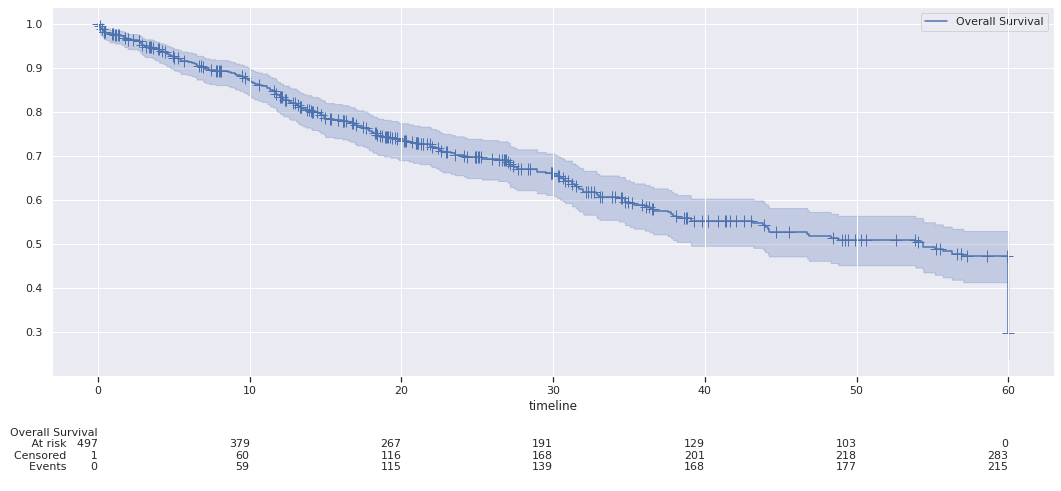

In [20]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=clinical_data["OS_MONTHS"],
        event_observed=clinical_data["OS_STATUS_B"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1, at_risk_counts=True)

In [21]:
#RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_RNA_Seq_v2_expression_median.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_mrna_seq_v2_rsem.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
linearCNA = pd.read_csv(os.path.join(data_directory, study_name, "data_linear_cna.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
methylation_hm450 = pd.read_csv(os.path.join(data_directory, study_name, "data_methylation_hm450.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")

RNAseq.shape[0], linearCNA.shape[0], methylation_hm450.shape[0]

(20531, 24776, 16714)

Remove any columns with a mode with more than 20% frequency

In [22]:
RNAseq_t = remove_columns_with_significant_modes(RNAseq.transpose()).dropna(axis="columns")
RNAseq_t = RNAseq_t.rename(lambda x: x+"_mrna", axis="columns")
linearCNA_t = remove_columns_with_significant_modes(linearCNA.transpose()).dropna(axis="columns")
linearCNA_t = linearCNA_t.rename(lambda x: x+"_lcna", axis="columns")
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450.transpose()).dropna(axis="columns")
methylation_hm450_t = methylation_hm450_t.rename(lambda x: x+"_methy", axis="columns")
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

In [23]:
RNAseq_t = (RNAseq_t)
linearCNA_t = (linearCNA_t)
methylation_hm450_t = remove_columns_with_significant_modes(methylation_hm450_t)
RNAseq_t.shape[-1], linearCNA_t.shape[-1], methylation_hm450_t.shape[-1]

(16827, 24754, 15854)

Trying to find a column in our dataset that maps approximately or exactly to another on the other dataframe.

In [24]:
smpls = ['TCGA-18-3408-01', 'TCGA-18-3409-01', 'TCGA-18-3410-01']
vals = np.array([[0],[0],[7.8777]])
eps=1e-1

RNAseq_t.loc[:,((RNAseq_t.loc[smpls]-vals)**2<eps).all(axis="rows")]

Hugo_Symbol,EFCAB8_mrna,H3FM_mrna
TCGA-18-3406-01,4.7244,0.7874
TCGA-18-3407-01,0.9515,0.9515
TCGA-18-3408-01,0.0000,0.0000
TCGA-18-3409-01,0.0000,0.0000
TCGA-18-3410-01,7.8777,7.8777
...,...,...
TCGA-O2-A52S-01,2.4834,13.2450
TCGA-O2-A52V-01,5.8830,5.8830
TCGA-O2-A52W-01,6.4481,9.1349
TCGA-O2-A5IB-01,2.1299,15.9744


$EFCAB8_{mrna} \rightarrow X388795_{RNAseq}$

In [25]:
RNAseq_t.max().max()

1737511.5871

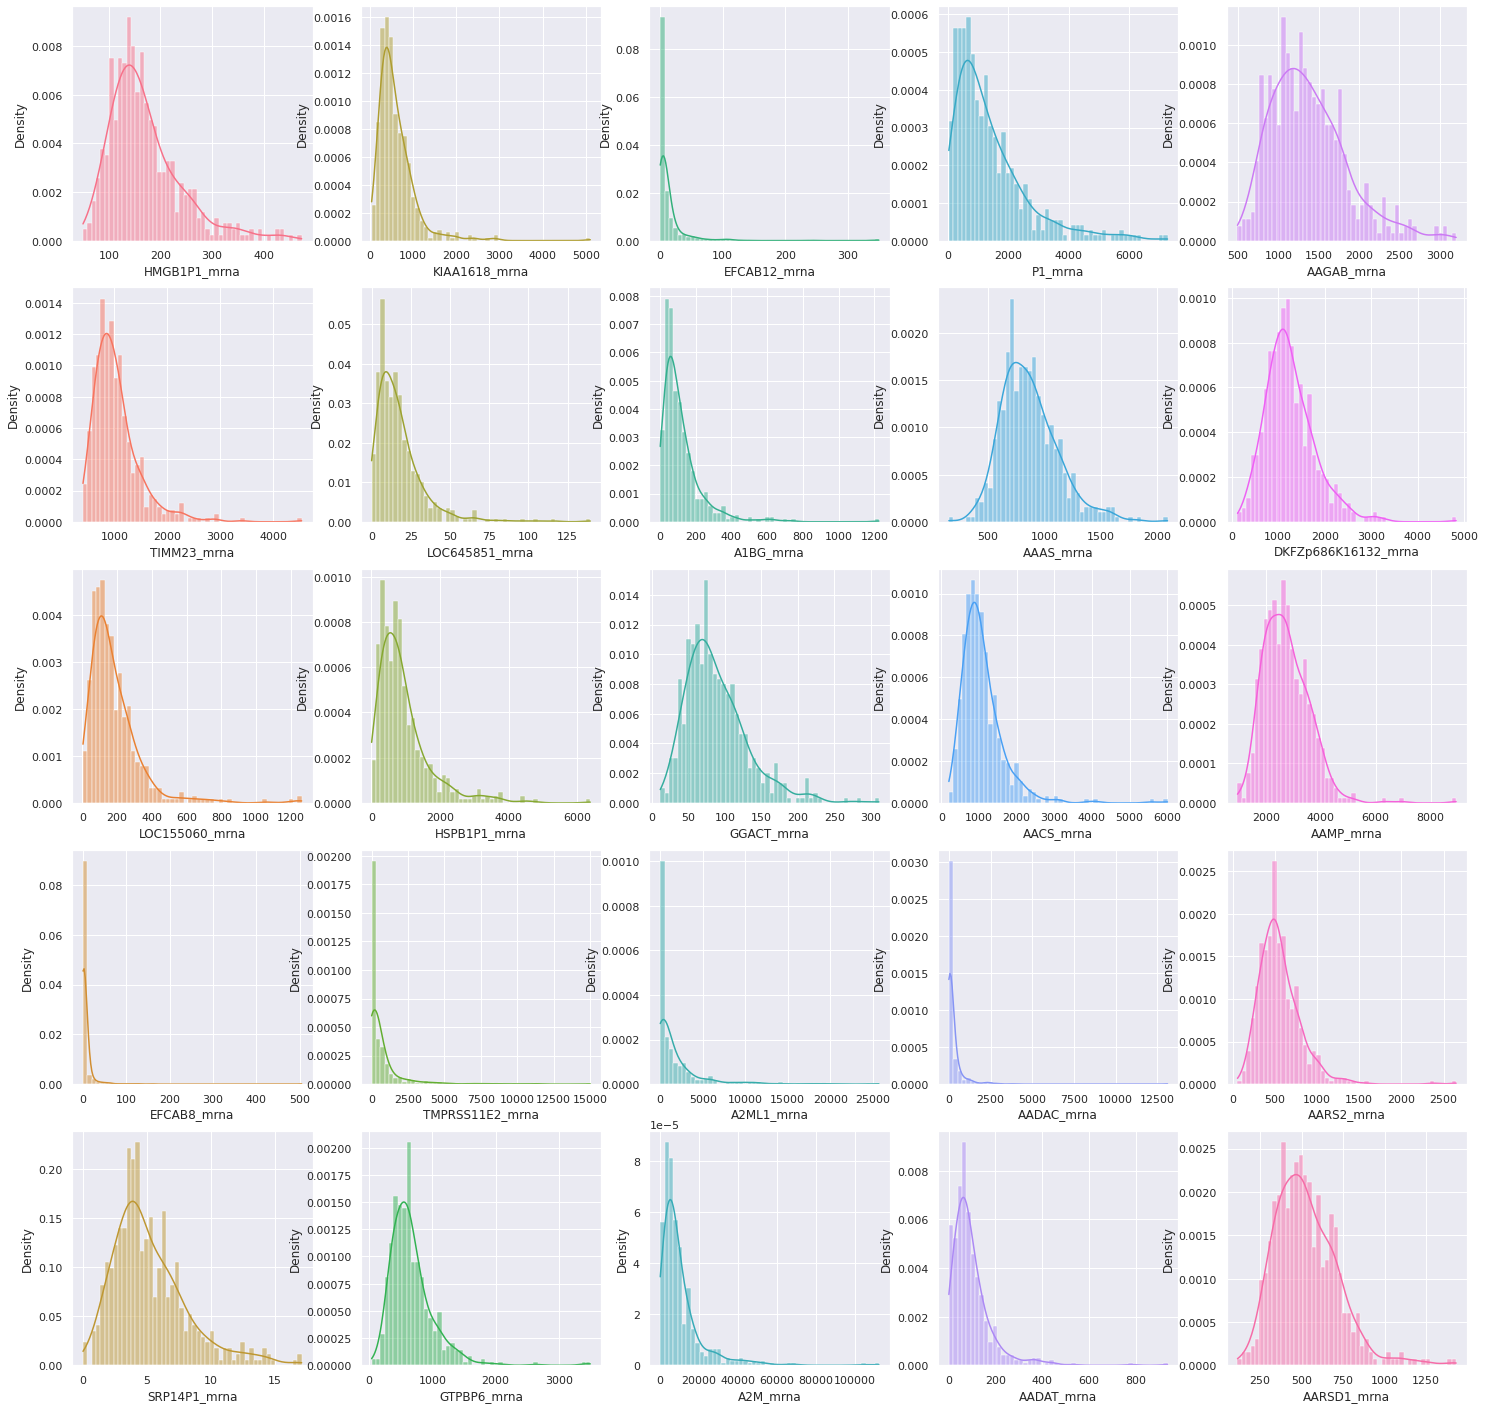

In [26]:
get_histograms_from_columns(RNAseq_t, RNAseq_t.columns[:25])
pass

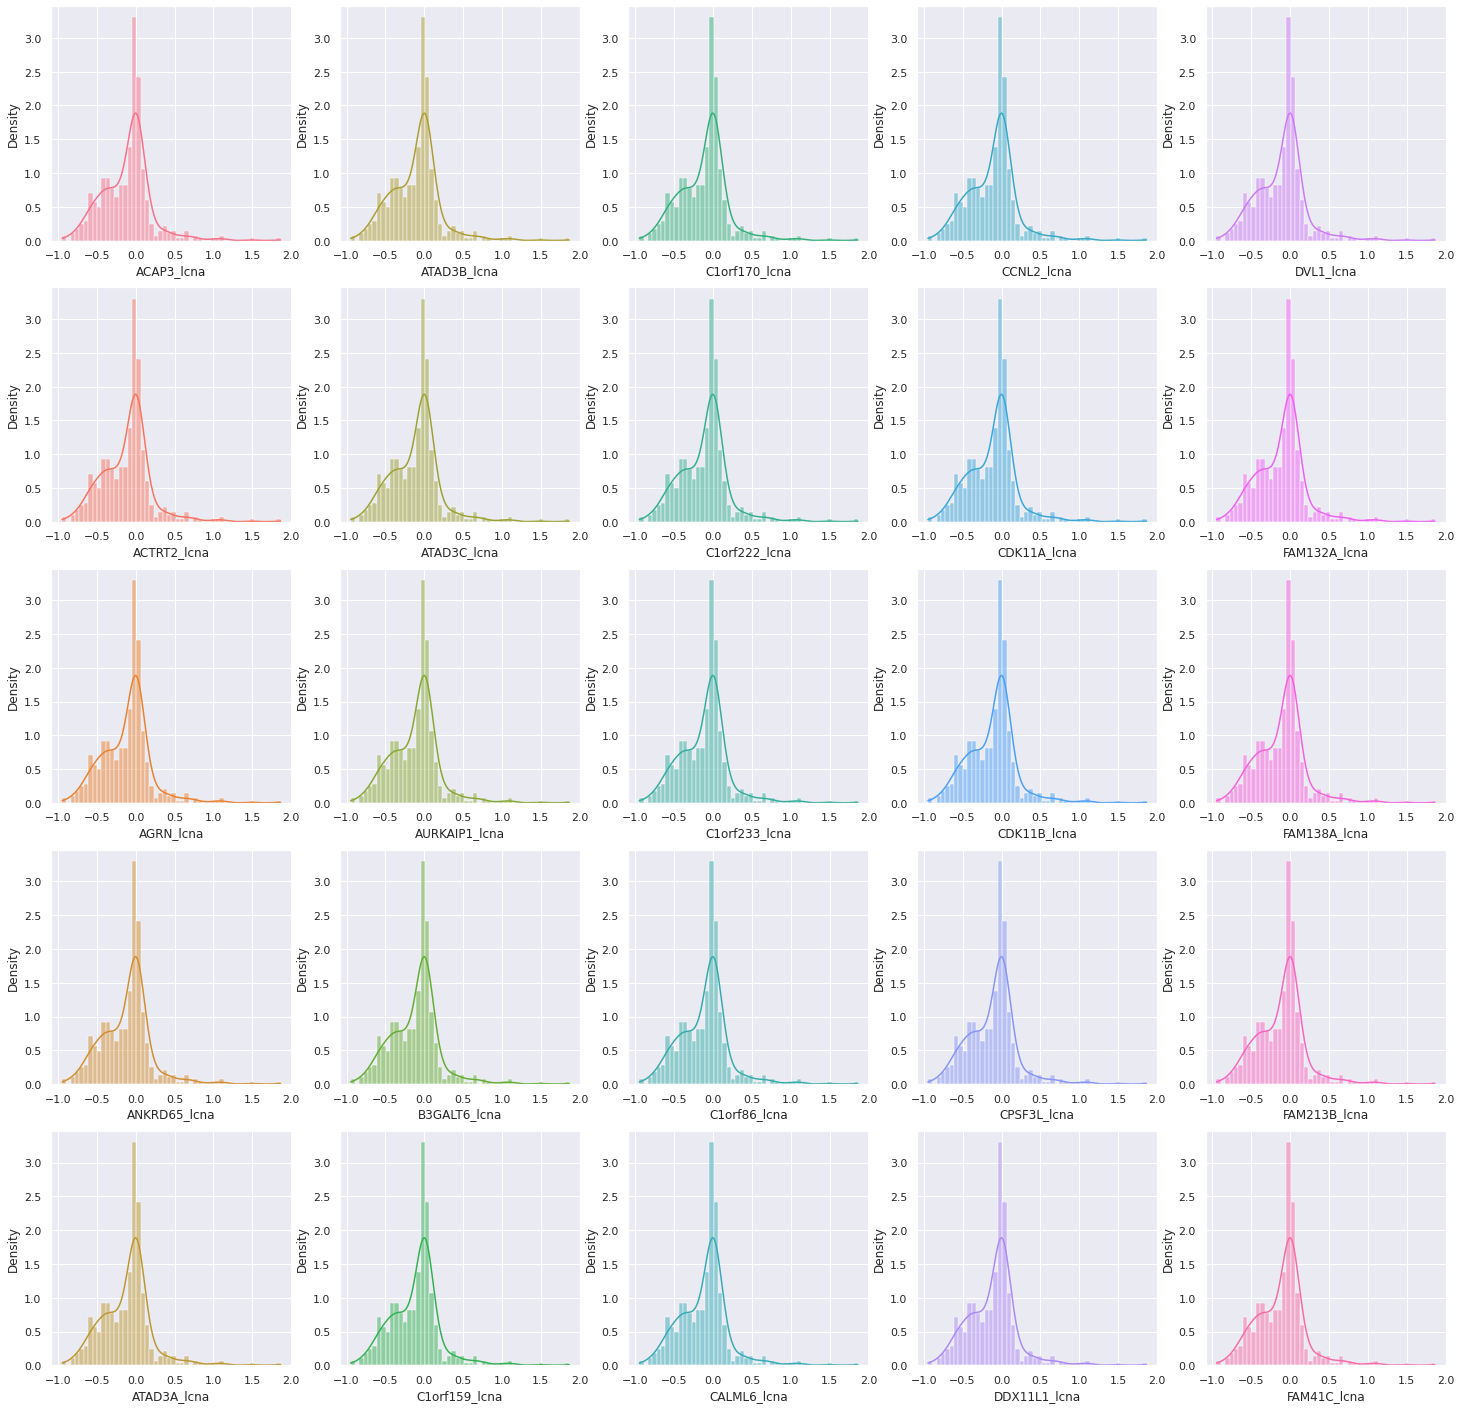

In [27]:
get_histograms_from_columns(linearCNA_t, linearCNA_t.columns[:25])
pass

In [28]:
# This takes a long time. The result is cached below.
use_cached_duplicate_columns_for_linear_cna = True
if use_cached_duplicate_columns_for_linear_cna:
    # Only run until 576/24754 
    duplicate_columns = ['ACTRT2_lcna', 'AGRN_lcna', 'ANKRD65_lcna', 'ATAD3A_lcna', 'ATAD3B_lcna', 'ATAD3C_lcna', 'AURKAIP1_lcna', 'B3GALT6_lcna', 'C1orf159_lcna', 'C1orf170_lcna', 'C1orf222_lcna', 'C1orf233_lcna', 'C1orf86_lcna', 'CALML6_lcna', 'CCNL2_lcna', 'CDK11A_lcna', 'CDK11B_lcna', 'CPSF3L_lcna', 'DDX11L1_lcna', 'DVL1_lcna', 'FAM132A_lcna', 'FAM138A_lcna', 'FAM213B_lcna', 'FAM41C_lcna', 'FAM87B_lcna', 'GABRD_lcna', 'GLTPD1_lcna', 'GNB1_lcna', 'HES4_lcna', 'HES5_lcna', 'ISG15_lcna', 'KLHL17_lcna', 'LINC00115_lcna', 'LINC00982_lcna', 'MIB2_lcna', 'MIR200A_lcna', 'MIR200B_lcna', 'MIR429_lcna', 'MMEL1_lcna', 'MMP23B_lcna', 'MORN1_lcna', 'MRPL20_lcna', 'MXRA8_lcna', 'NADK_lcna', 'NOC2L_lcna', 'OR4F16_lcna', 'OR4F29_lcna', 'OR4F5_lcna', 'PANK4_lcna', 'PEX10_lcna', 'PLCH2_lcna', 'PLEKHN1_lcna', 'PRDM16_lcna', 'PRKCZ_lcna', 'PUSL1_lcna', 'RER1_lcna', 'RN7SL657P_lcna', 'RNF223_lcna', 'SAMD11_lcna', 'SCNN1D_lcna', 'SDF4_lcna', 'SKI_lcna', 'SLC35E2B_lcna', 'SLC35E2_lcna', 'SSU72_lcna', 'TAS1R3_lcna', 'TMEM240_lcna', 'TMEM52_lcna', 'TMEM88B_lcna', 'TNFRSF14_lcna', 'TNFRSF18_lcna', 'TNFRSF4_lcna', 'TTC34_lcna', 'TTLL10_lcna', 'UBE2J2_lcna', 'VWA1_lcna', 'SMIM1_lcna', 'LRRC47_lcna', 'RN7SL574P_lcna', 'RNF207_lcna', 'ICMT_lcna', 'GPR153_lcna', 'HES3_lcna', 'ACOT7_lcna', 'PLEKHG5_lcna', 'TNFRSF25_lcna', 'KLHL21_lcna', 'THAP3_lcna', 'PER3_lcna', 'UTS2_lcna', 'ERRFI1_lcna', 'RN7SL451P_lcna', 'SLC2A7_lcna', 'GPR157_lcna', 'H6PD_lcna', 'TMEM201_lcna', 'C1orf200_lcna', 'NMNAT1_lcna', 'RN7SKP269_lcna', 'MIR5697_lcna', 'RN7SL731P_lcna', 'APITD1_lcna', 'DFFA_lcna', 'TARDBP_lcna', 'MASP2_lcna', 'SRM_lcna', 'EXOSC10_lcna', 'MTOR_lcna', 'snoU13|ENSG00000271794.1_lcna', 'ANGPTL7_lcna', 'PTCHD2_lcna', 'FBXO44_lcna', 'FBXO6_lcna', 'MAD2L2_lcna', 'DRAXIN_lcna', 'MTHFR_lcna', 'CLCN6_lcna', 'KIAA2013_lcna', 'PLOD1_lcna', 'MIIP_lcna', 'RN7SL649P_lcna', 'MIR4632_lcna', 'SNORA70|ENSG00000252969.1_lcna', 'snoU13|ENSG00000238771.1_lcna', 'PRAMEF10_lcna', 'PRAMEF11_lcna', 'PRAMEF12_lcna', 'PRAMEF13_lcna', 'PRAMEF14_lcna', 'PRAMEF15_lcna', 'PRAMEF16_lcna', 'PRAMEF17_lcna', 'PRAMEF18_lcna', 'PRAMEF19_lcna', 'PRAMEF1_lcna', 'PRAMEF21_lcna', 'PRAMEF22_lcna', 'PRAMEF2_lcna', 'PRAMEF3_lcna', 'PRAMEF4_lcna', 'PRAMEF5_lcna', 'PRAMEF6_lcna', 'PRAMEF7_lcna', 'PRAMEF8_lcna', 'PRAMEF9_lcna', 'PRAMEF20_lcna', 'LRRC38_lcna', 'C1orf195_lcna', 'FHAD1_lcna', 'CELA2A_lcna', 'CELA2B_lcna', 'CASP9_lcna', 'SCARNA21|ENSG00000251866.1_lcna', 'AGMAT_lcna', 'RSC1A1_lcna', 'PLEKHM2_lcna', 'FBLIM1_lcna', 'SLC25A34_lcna', 'TMEM82_lcna', 'SPEN_lcna', 'snoU13|ENSG00000238818.1_lcna', 'ZBTB17_lcna', 'CLCNKA_lcna', 'CLCNKB_lcna', 'FAM131C_lcna', 'C1ORF134_lcna', 'RSG1_lcna', 'SZRD1_lcna', 'CROCCP2_lcna', 'CROCC_lcna', 'ESPNP_lcna', 'MFAP2_lcna', 'MIR3675_lcna', 'MST1L_lcna', 'NBPF1_lcna', 'U1|ENSG00000228549.2_lcna', 'U1|ENSG00000233421.3_lcna', 'PADI2_lcna', 'MIR3972_lcna', 'PADI6_lcna', 'snoU13|ENSG00000239020.1_lcna', 'ALDH4A1_lcna', 'MIR4695_lcna', 'MIR1290_lcna', 'MRTO4_lcna', 'AKR7A3_lcna', 'AKR7L_lcna', 'PQLC2_lcna', 'RN7SL85P_lcna', 'RN7SL277P_lcna', 'MINOS1_lcna', 'NBL1_lcna', 'HTR6_lcna', 'OTUD3_lcna', 'PLA2G2A_lcna', 'RN7SL304P_lcna', 'PLA2G2D_lcna', 'PLA2G2C_lcna', 'UBXN10_lcna', 'VWA5B1_lcna', 'MUL1_lcna', 'FAM43B_lcna', 'CDA_lcna', 'PINK1_lcna', 'DDOST_lcna', 'SH2D5_lcna', 'NBPF3_lcna', 'HSPG2_lcna', 'CELA3A_lcna', 'CELA3B_lcna', 'LINC00339_lcna', 'RN7SL186P_lcna', 'RN7SL386P_lcna', 'RN7SL421P_lcna', 'RN7SL768P_lcna', 'WNT4_lcna', 'EPHA8_lcna', 'C1QA_lcna', 'C1QC_lcna', 'C1QB_lcna', 'MIR4253_lcna', 'C1orf234_lcna', 'MIR4419A_lcna', 'ZNF436_lcna', 'C1orf213_lcna', 'TCEA3_lcna', 'E2F2_lcna', 'ID3_lcna', 'RN7SL532P_lcna', 'TCEB3_lcna', 'PITHD1_lcna', 'LYPLA2_lcna', 'FUCA1_lcna', 'CNR2_lcna', 'RN7SL24P_lcna', 'snoU13|ENSG00000238538.1_lcna', 'MIR378F_lcna', 'PNRC2_lcna', 'SRSF10_lcna', 'IFNLR1_lcna', 'STPG1_lcna', 'NIPAL3_lcna', 'RN7SL857P_lcna', 'NCMAP_lcna', 'snoU13|ENSG00000238986.1_lcna', 'RHCE_lcna', 'RHD_lcna', 'SYF2_lcna', 'TMEM50A_lcna', 'snoU13|ENSG00000238889.1_lcna', 'LDLRAP1_lcna', 'MTFR1L_lcna', 'AUNIP_lcna', 'PAQR7_lcna', 'STMN1_lcna', 'MIR3917_lcna', 'SCARNA17|ENSG00000252190.1_lcna', 'SCARNA18|ENSG00000252691.1_lcna', 'EXTL1_lcna', 'SLC30A2_lcna', 'TRIM63_lcna', 'FAM110D_lcna', 'ZNF593_lcna', 'CATSPER4_lcna', 'CEP85_lcna', 'SH3BGRL3_lcna', 'UBXN11_lcna', 'CD52_lcna', 'RN7SL490P_lcna', 'ZNF683_lcna', 'LIN28A_lcna', 'HMGN2_lcna', 'RPS6KA1_lcna', 'MIR1976_lcna', 'RN7SL501P_lcna', 'RN7SL165P_lcna', 'ZDHHC18_lcna', 'GPATCH3_lcna', 'NR0B2_lcna', 'TRNP1_lcna', 'FAM46B_lcna', 'SYTL1_lcna', 'MAP3K6_lcna', 'FCN3_lcna', 'CD164L2_lcna', 'GPR3_lcna', 'IFI6_lcna', 'FAM76A_lcna', 'SCARNA1_lcna', 'THEMIS2_lcna', 'SMPDL3B_lcna', 'EYA3_lcna', 'RN7SL559P_lcna', 'SESN2_lcna', 'RCC1_lcna', 'SNHG3_lcna', 'SNORA73B_lcna', 'snoU13|ENSG00000238821.1_lcna', 'TRNAU1AP_lcna', 'SNHG12_lcna', 'SNORD99_lcna', 'RAB42_lcna', 'RNU11_lcna', 'GMEB1_lcna', 'SCARNA24|ENSG00000252777.1_lcna', 'YTHDF2_lcna', 'TMEM200B_lcna', 'SRSF4_lcna', 'MATN1_lcna', 'MIR4420_lcna', 'SNORD85_lcna', 'PEF1_lcna', 'MIR4254_lcna', 'PTP4A2_lcna', 'MIR5585_lcna', 'CCDC28B_lcna', 'IQCC_lcna', 'DCDC2B_lcna', 'TMEM234_lcna', 'EIF3I_lcna', 'MTMR9LP_lcna', 'FAM167B_lcna', 'HDAC1_lcna', 'BSDC1_lcna', 'FAM229A_lcna', 'ZBTB8B_lcna', 'S100PBP_lcna', 'FNDC5_lcna', 'HPCA_lcna', 'TMEM54_lcna', 'RNF19B_lcna', 'FKSG48_lcna', 'A3GALT2_lcna', 'MIR3605_lcna', 'RN7SKP16_lcna', 'GJB5_lcna', 'GJB4_lcna', 'GJB3_lcna', 'GJA4_lcna', 'ZMYM6_lcna']
else:
    duplicate_columns = get_columns_with_duplicates(linearCNA_t, disable_tqdm=False)
    print(duplicate_columns)

['ACTRT2_lcna', 'AGRN_lcna', 'ANKRD65_lcna', 'ATAD3A_lcna', 'ATAD3B_lcna', 'ATAD3C_lcna', 'AURKAIP1_lcna', 'B3GALT6_lcna', 'C1orf159_lcna', 'C1orf170_lcna', 'C1orf222_lcna', 'C1orf233_lcna', 'C1orf86_lcna', 'CALML6_lcna', 'CCNL2_lcna', 'CDK11A_lcna', 'CDK11B_lcna', 'CPSF3L_lcna', 'DDX11L1_lcna', 'DVL1_lcna', 'FAM132A_lcna', 'FAM138A_lcna', 'FAM213B_lcna', 'FAM41C_lcna', 'FAM87B_lcna', 'GABRD_lcna', 'GLTPD1_lcna', 'GNB1_lcna', 'HES4_lcna', 'HES5_lcna', 'ISG15_lcna', 'KLHL17_lcna', 'LINC00115_lcna', 'LINC00982_lcna', 'MIB2_lcna', 'MIR200A_lcna', 'MIR200B_lcna', 'MIR429_lcna', 'MMEL1_lcna', 'MMP23B_lcna', 'MORN1_lcna', 'MRPL20_lcna', 'MXRA8_lcna', 'NADK_lcna', 'NOC2L_lcna', 'OR4F16_lcna', 'OR4F29_lcna', 'OR4F5_lcna', 'PANK4_lcna', 'PEX10_lcna', 'PLCH2_lcna', 'PLEKHN1_lcna', 'PRDM16_lcna', 'PRKCZ_lcna', 'PUSL1_lcna', 'RER1_lcna', 'RN7SL657P_lcna', 'RNF223_lcna', 'SAMD11_lcna', 'SCNN1D_lcna', 'SDF4_lcna', 'SKI_lcna', 'SLC35E2B_lcna', 'SLC35E2_lcna', 'SSU72_lcna', 'TAS1R3_lcna', 'TMEM240_lcn

In [29]:
len(duplicate_columns)

340

In [30]:
linearCNA_t = linearCNA_t.drop(columns=duplicate_columns)

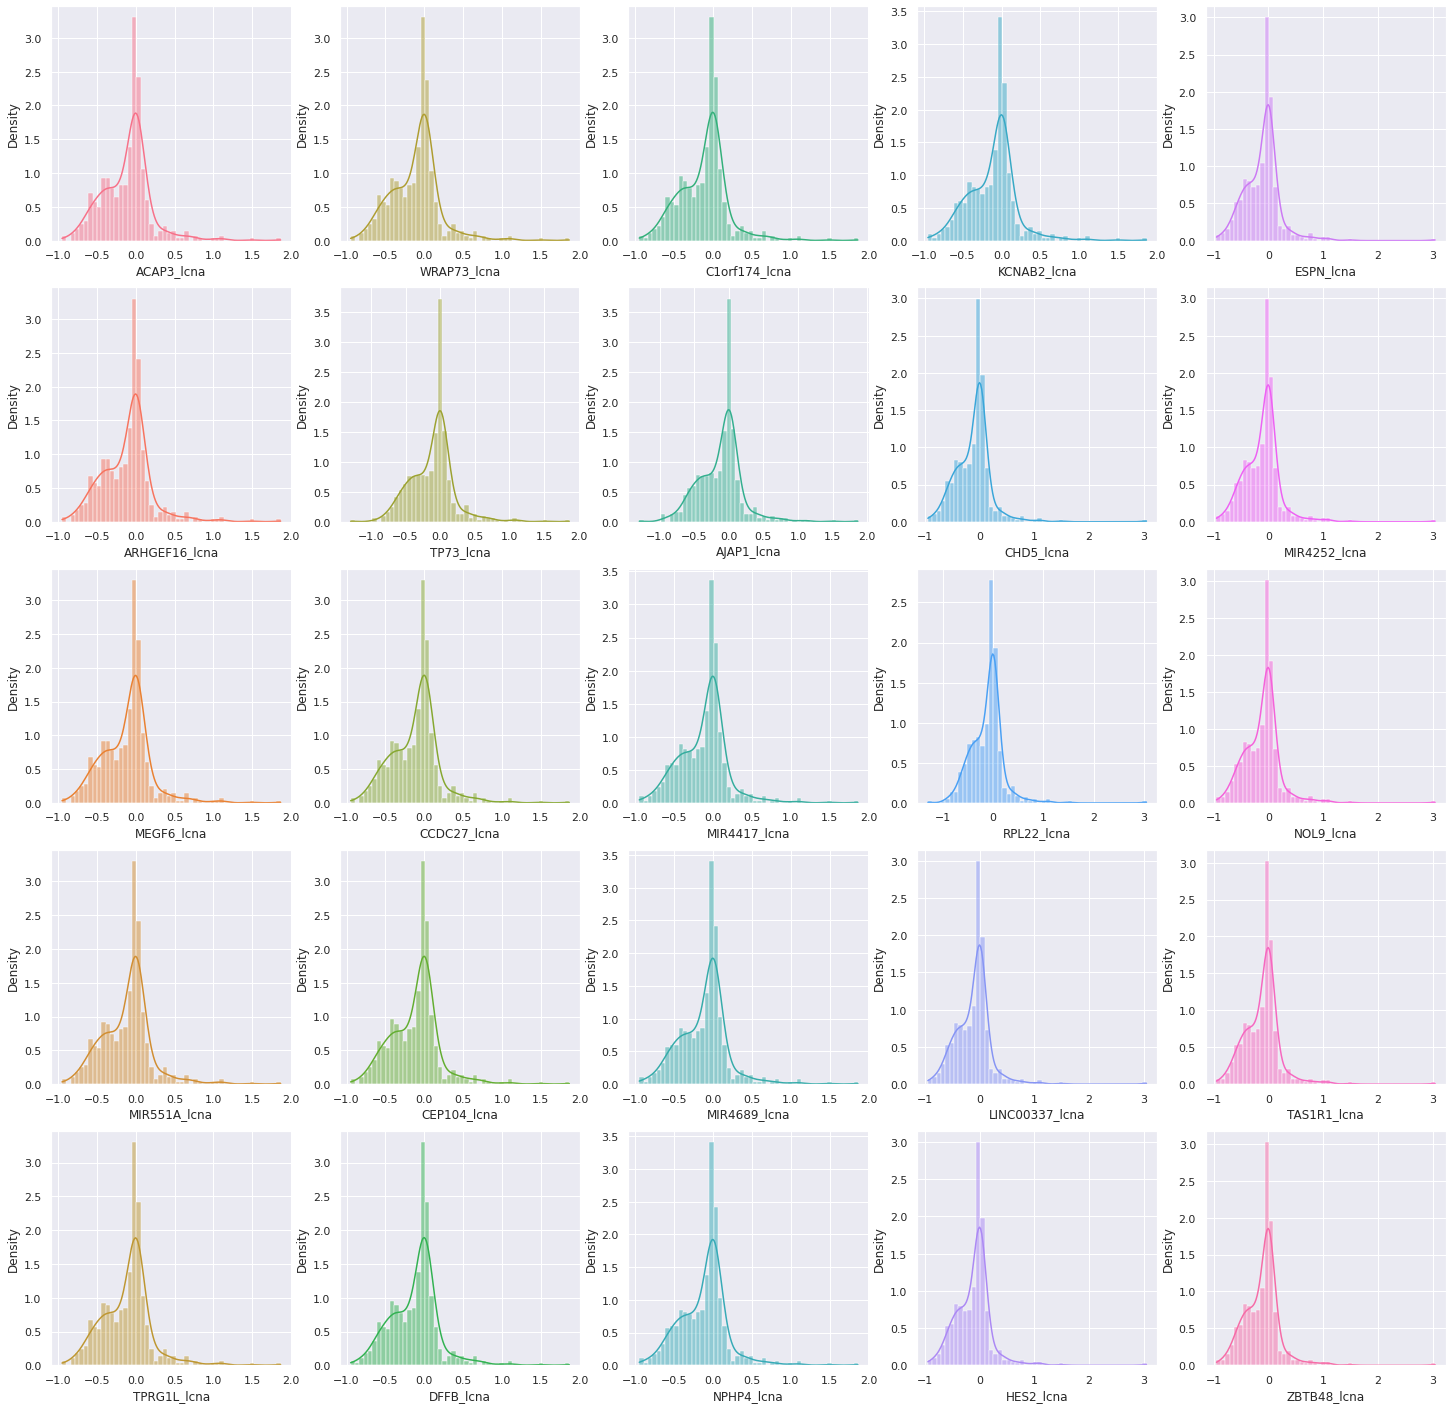

In [31]:
get_histograms_from_columns(linearCNA_t, linearCNA_t.columns[:25])
pass

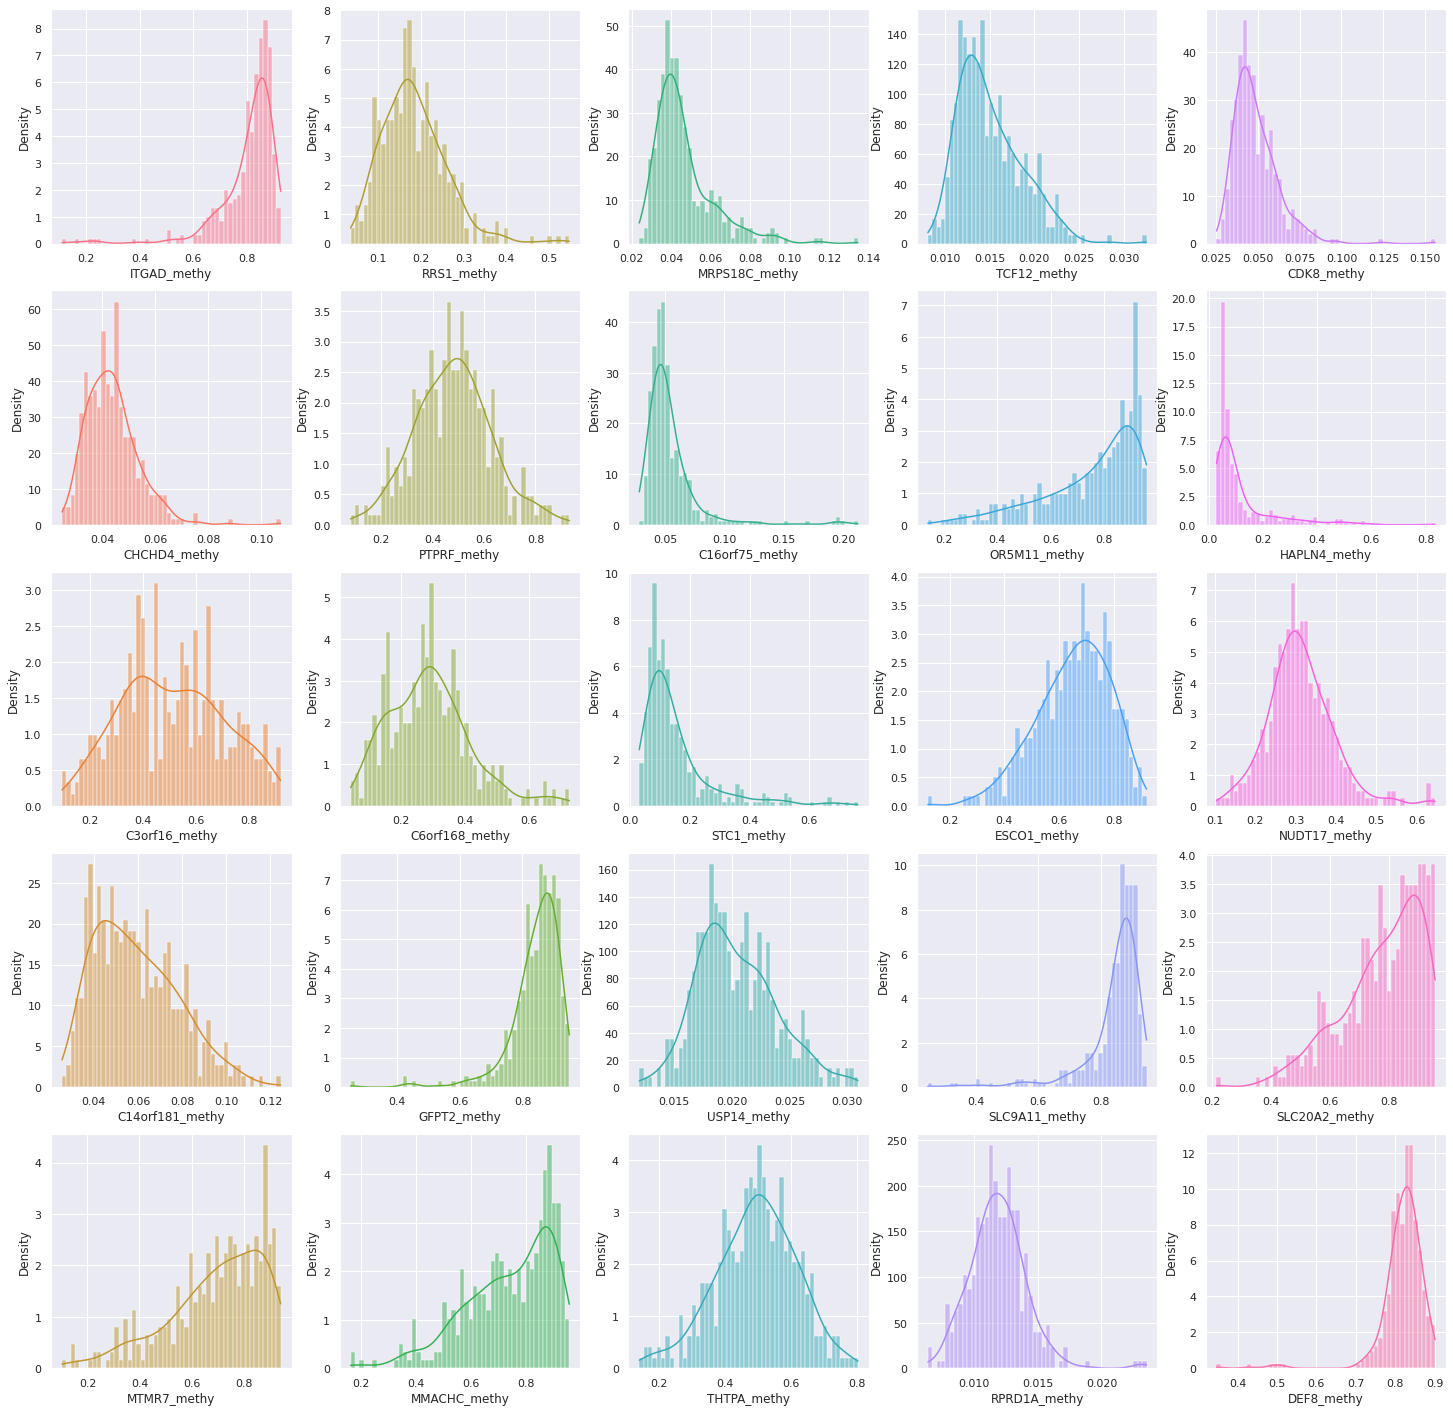

In [32]:
get_histograms_from_columns(methylation_hm450_t, methylation_hm450_t.columns[:25])
pass

Rebuild non-transposed dataframes

In [33]:
RNAseq = RNAseq_t.transpose()
linearCNA = linearCNA_t.transpose()
methylation_hm450 = methylation_hm450_t.transpose()
len(RNAseq), len(linearCNA), len(methylation_hm450)

(16827, 24414, 15854)

### miRNA data from gdc.cancer.gov

In [34]:
mirna_files_df = get_mirna_files()
mirna_files_df.describe()

,cases.0.samples.0.submitter_id,file_name,id
count,523,523,523
unique,523,523,523
top,TCGA-22-1011-01A,7df584d3-5b11-4987-8227-6d809e8305af.mirbase21...,07fa22d0-99b1-4364-9b93-d937005a2416
freq,1,1,1


In [35]:
#mirna_fname = download_mirna_files(mirna_files_df, data_directory)
#mirna_fname = "gdc_download_20211114_175949.738652.tar.gz"
mirna_fname = "gdc_download_20211118_203457.926713.tar.gz"

In [36]:
miRNA_df_t = untar_and_merge_mirna_files(mirna_files_df, mirna_fname, data_directory)
print("All columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_constant_columns(miRNA_df_t).dropna(axis="columns")
print("Only non-constant columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_columns_with_significant_modes(miRNA_df_t)
print("Only non-mode-dominant columns:", len(miRNA_df_t.columns))
miRNA_df = miRNA_df_t.transpose()
miRNA_df.to_csv("miRNA.csv", index_label="miRNA")
miRNA_df_t = miRNA_df_t.rename(lambda x: x+"_mirna", axis="columns")

All columns: 1881
Only non-constant columns: 1585
Only non-mode-dominant columns: 413


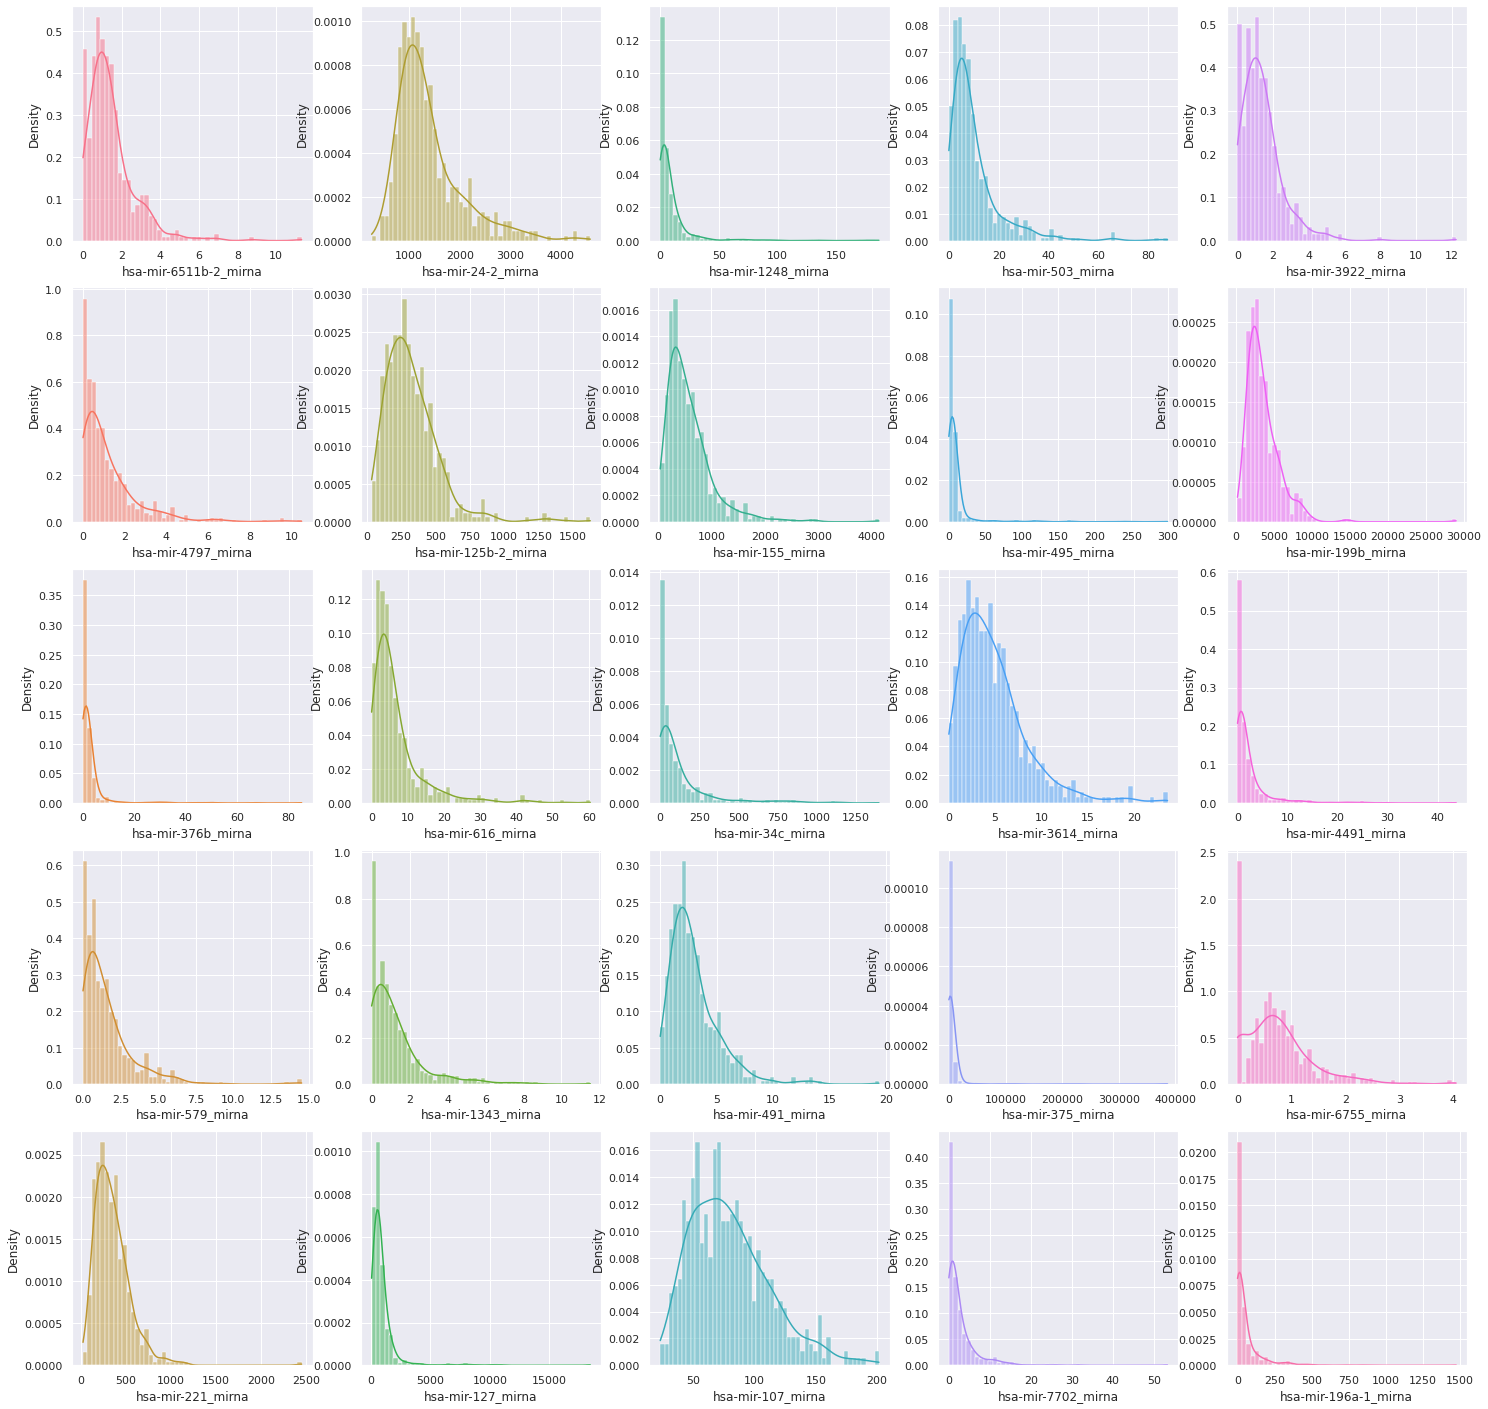

In [37]:
get_histograms_from_columns(miRNA_df_t, miRNA_df_t.columns[:25])
pass

In [38]:
#This takes about a minute. The result is cached below.
use_cached_duplicate_columns_for_mirna = True
if use_cached_duplicate_columns_for_mirna:
    duplicate_columns = []
else:
    duplicate_columns = get_columns_with_duplicates(miRNA_df_t, disable_tqdm=False)
    print(duplicate_columns)

In [39]:
(miRNA_df_t['hsa-mir-1226_mirna'] - miRNA_df_t['hsa-mir-205_mirna']).mean()

-14596.693915101338

In [40]:
abs(miRNA_df_t['hsa-mir-1226_mirna'] - miRNA_df_t['hsa-mir-205_mirna']).mean()

14596.693915101338

In [41]:
(miRNA_df_t['hsa-mir-1226_mirna'] - miRNA_df_t['hsa-mir-205_mirna']).sum()

-7634070.917598

In [42]:
abs(miRNA_df_t['hsa-mir-1226_mirna'] - miRNA_df_t['hsa-mir-205_mirna']).sum()

7634070.917598

In [43]:
set(miRNA_df_t.columns) - set(duplicate_columns)

{'hsa-let-7a-1_mirna',
 'hsa-let-7a-2_mirna',
 'hsa-let-7a-3_mirna',
 'hsa-let-7b_mirna',
 'hsa-let-7c_mirna',
 'hsa-let-7d_mirna',
 'hsa-let-7e_mirna',
 'hsa-let-7f-1_mirna',
 'hsa-let-7f-2_mirna',
 'hsa-let-7g_mirna',
 'hsa-let-7i_mirna',
 'hsa-mir-1-1_mirna',
 'hsa-mir-1-2_mirna',
 'hsa-mir-100_mirna',
 'hsa-mir-101-1_mirna',
 'hsa-mir-101-2_mirna',
 'hsa-mir-103a-1_mirna',
 'hsa-mir-103a-2_mirna',
 'hsa-mir-105-1_mirna',
 'hsa-mir-105-2_mirna',
 'hsa-mir-106a_mirna',
 'hsa-mir-106b_mirna',
 'hsa-mir-107_mirna',
 'hsa-mir-10a_mirna',
 'hsa-mir-10b_mirna',
 'hsa-mir-1180_mirna',
 'hsa-mir-1226_mirna',
 'hsa-mir-1228_mirna',
 'hsa-mir-1245a_mirna',
 'hsa-mir-1247_mirna',
 'hsa-mir-1248_mirna',
 'hsa-mir-1249_mirna',
 'hsa-mir-125a_mirna',
 'hsa-mir-125b-1_mirna',
 'hsa-mir-125b-2_mirna',
 'hsa-mir-1262_mirna',
 'hsa-mir-1266_mirna',
 'hsa-mir-1269a_mirna',
 'hsa-mir-126_mirna',
 'hsa-mir-1270_mirna',
 'hsa-mir-1271_mirna',
 'hsa-mir-1277_mirna',
 'hsa-mir-127_mirna',
 'hsa-mir-128-1_m

## Reconciling data from cBioPortal and gdc.cancer.gov

In [44]:
clinical_patients = set(clinical_data.index)
RNAseq_patients = set(RNAseq_t.index)
linearCNA_patients = set(linearCNA_t.index)
methylation_hm450_patients = set(methylation_hm450_t.index)
miRNA_patients = set(miRNA_df_t.index)
all_sets = [clinical_patients, RNAseq_patients, linearCNA_patients, methylation_hm450_patients, miRNA_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [45]:
list(map(len, all_sets))

[498, 501, 501, 370, 523]

In [46]:
len(all_patients), len(patients_on_all_datasets)

(549, 356)

In [47]:
clinical_columns = set(clinical_data.columns)
RNAseq_columns = set(RNAseq_t.columns)
linearCNA_columns = set(linearCNA_t.columns)
methylation_hm450_columns = set(methylation_hm450_t.columns)
miRNA_columns = set(miRNA_df_t.columns)
all_col_sets = [clinical_columns, RNAseq_columns, linearCNA_columns, miRNA_columns]
all_columns = functools.reduce(lambda x, y: x|y, all_col_sets, set())
columns_on_all_datasets = functools.reduce(lambda x, y: x&y, all_col_sets, all_columns)

In [48]:
list(map(len, all_col_sets))

[3, 16827, 24414, 413]

In [49]:
len(all_columns), len(columns_on_all_datasets)

(41657, 0)

In [50]:
[(i,j,len(all_col_sets[i]&all_col_sets[j])) for i in range(len(all_col_sets)) for j in range(i+1,len(all_col_sets))]

[(0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 2, 0), (1, 3, 0), (2, 3, 0)]

In [51]:
df_clin = clinical_data.loc[patients_on_all_datasets]
df_mrna = RNAseq_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
df_lcna = linearCNA_t.loc[patients_on_all_datasets]
df_methy = methylation_hm450_t.loc[patients_on_all_datasets]
df_mirna = miRNA_df_t.loc[patients_on_all_datasets].apply(lambda x: np.log2(x+1))
feature_dfs = [df_mrna, df_lcna, df_methy, df_mirna]

In [52]:
df_ae = functools.reduce(lambda x,y: x.join(y), feature_dfs[1:], feature_dfs[0])
X_ae = scale(df_ae)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


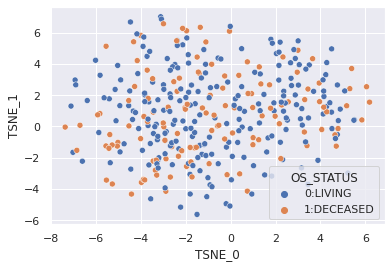

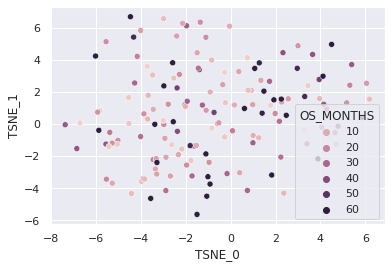

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-2.482155,3.964683,TCGA-NC-A5HG-01,0:LIVING,60.00,False
1,-5.366844,-2.324843,TCGA-39-5035-01,0:LIVING,60.00,False
2,-1.612275,-1.369837,TCGA-60-2704-01,1:DECEASED,37.91,True
3,2.670278,4.073665,TCGA-39-5027-01,0:LIVING,60.00,False
4,5.393797,3.706305,TCGA-22-4601-01,1:DECEASED,34.72,True
...,...,...,...,...,...,...
351,4.757915,2.654266,TCGA-85-8354-01,0:LIVING,32.69,False
352,2.356266,0.976597,TCGA-34-5240-01,0:LIVING,50.62,False
353,4.149545,1.232895,TCGA-58-A46K-01,1:DECEASED,34.33,True
354,-6.854785,-1.528510,TCGA-39-5034-01,1:DECEASED,36.37,True


In [53]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(X_ae), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

## Integrating the Data With an Autoencoder

In [54]:
column_sizes = functools.reduce(lambda x,y: x+[x[-1]+y], [len(df.columns) for df in feature_dfs], [0])
column_sizes

[0, 16827, 41241, 57095, 57508]

In [55]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

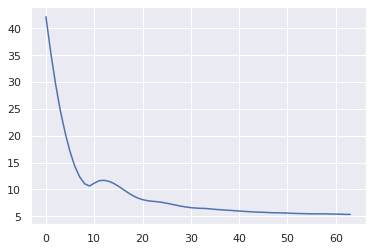

In [109]:
d_in = X_ae.shape[-1]

ae = Autoencoder(
        input_dim = d_in,
        hidden_dims = [512],
        encoding_dim = 128,
        nonlinearity = F.relu,#torch.tanh,
        final_nonlinearity = lambda x:x,#torch.tanh,
        dropout_rate = 0.3,
        bias = True)
ae.apply(init_weights)

parameter_normalizations = [(1e-3, 1)]
activation_normalizations = [(1e-4, 2)]
average_norms = True
l2_weight_decay = 0#1e-4

opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay = l2_weight_decay)

tX_ae = torch.tensor(X_ae, dtype=torch.float32)

epochs = 64
losses = []
for e in range(epochs):
    act_norms = 0
    act_norms_count = 0
    param_norms = 0
    param_norms_count = 0
    
    if activation_normalizations is not None and len(activation_normalizations) > 0:
        activations = ae.layer_activations(tX_ae)
        y = activations[-1]
        for norm_weight, norm_type in activation_normalizations:
            act_norms += norm_weight * sum((torch.norm(acts, norm_type) for acts in activations))/len(activations)
            act_norms_count += 1
        act_norms /= act_norms_count if average_norms else 1
    else:
        y = ae(tX_ae)
    acc = 0
    reconstruction_losses = [F.mse_loss(y[...,s:t], tX_ae[...,s:t]) for s,t in zip(column_sizes[:-1], column_sizes[1:])]
    
    for norm_weight, norm_type in parameter_normalizations:
        param_norms += norm_weight * sum((torch.norm(params, norm_type) for params in ae.parameters()))/len(list(ae.parameters()))
        param_norms_count += 1
    param_norms /= param_norms_count if average_norms else 1
        
    loss = sum(reconstruction_losses) + param_norms + act_norms
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.detach().numpy().item())
    print("{} {}".format(e, losses[-1]), end='\x1b[1K\r')
sns.lineplot(x=list(range(len(losses))), y=losses)

ae.eval()
integrated_values = ae.encode(tX_ae).detach().numpy()

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


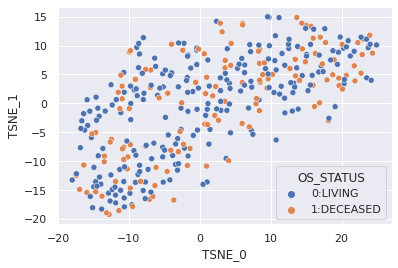

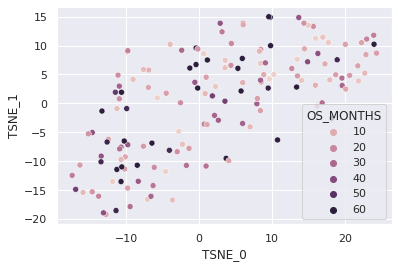

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,-14.646505,1.088454,TCGA-NC-A5HG-01,0:LIVING,60.00,False
1,11.177022,14.837783,TCGA-39-5035-01,0:LIVING,60.00,False
2,16.306604,8.631511,TCGA-60-2704-01,1:DECEASED,37.91,True
3,-14.332924,-9.052889,TCGA-39-5027-01,0:LIVING,60.00,False
4,-9.799991,-7.141448,TCGA-22-4601-01,1:DECEASED,34.72,True
...,...,...,...,...,...,...
351,-17.418814,-12.168857,TCGA-85-8354-01,0:LIVING,32.69,False
352,-10.682788,-16.342346,TCGA-34-5240-01,0:LIVING,50.62,False
353,-8.366667,-13.463002,TCGA-58-A46K-01,1:DECEASED,34.33,True
354,2.883971,13.863750,TCGA-39-5034-01,1:DECEASED,36.37,True


In [110]:
n_components = 2
df_plot = pd.DataFrame(dim_reduction(n_components).fit_transform(integrated_values), columns=[dim_reduction_label.format(i) for i in range(n_components)])
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

### Find the Significant Factors  

In [111]:
# Set the threshold for significance
significance_threshold = 0.05

significant_factors_list = []
logRank_Pvalues_list = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # logRank_Pvalues is a vector that will store the log-rank p-values of each 
    # univariate Cox-PH models built
    logRank_Pvalues = list()
    # significant_factors is a vector that will store every factor for which a 
    # significant Cox-PH model was built (log-rank P < 0.05)
    significant_factor_indexes = list()
    # Iterate over all factors/features of the actual dataframe
    for i in range(integrated_values.shape[1]):
        # Create a df with 3 columns, one for factor, one for OS_MONTHS
        # and one for OS_STATUS
        factor_df = pd.DataFrame(
            {
                "OS_MONTHS": df_clin["OS_MONTHS"].values,
                "OS_STATUS": df_clin["OS_STATUS_B"].values,
                "Factor_{}".format(i): integrated_values[:,i]
            }
        )
        # Build univariate COX-PH models
        cox_ph = lifelines.fitters.coxph_fitter.CoxPHFitter().fit(factor_df, "OS_MONTHS", "OS_STATUS")
        #log_rank_p_value = cox_ph.log_likelihood_ratio_test().p_value #summary["-log2(p)"][0]
        log_rank_p_value = cox_ph.summary["p"][0]
        if (log_rank_p_value<significance_threshold):
            significant_factor_indexes.append(i)
            logRank_Pvalues.append(log_rank_p_value)

    print("")
    print(significant_factor_indexes)
    print(logRank_Pvalues)


[2, 4, 7, 12, 15, 16, 19, 25, 34, 37, 54, 55, 78, 82, 90, 113, 119, 122, 125]
[0.034197030223477635, 0.03397108211977869, 0.022620760641748835, 0.046459310067754986, 0.04773870826513945, 0.034347825224474646, 0.0010534608277190634, 0.02735278482279645, 0.011409950451671895, 0.04412809188967722, 0.04644003454191632, 0.04878058270075757, 0.04146034965047504, 0.04283429157453193, 0.037966398428128906, 0.04437730378230433, 0.048085996663226944, 0.02014931752150395, 0.034736214476389964]


In [112]:
significant_factors = integrated_values[:,significant_factor_indexes]
significant_factors

array([[  2.1991975 , -12.559479  ,   6.582347  , ...,  -4.569784  ,
          8.430134  ,  -6.1469197 ],
       [  1.9404602 ,   0.97718614,   2.2143056 , ...,  -0.10001868,
         -5.8512635 ,   0.3168568 ],
       [ -3.475822  ,   0.9485143 ,  -3.744104  , ...,   2.5682945 ,
         -4.1414137 ,   1.5651188 ],
       ...,
       [ -0.6557696 ,   0.3170638 ,  -0.33267936, ...,  -3.387129  ,
         -0.06621635,  -5.5102043 ],
       [  0.12889074,   2.5964167 ,   1.6895394 , ...,   2.5935898 ,
         -2.618755  ,   3.7418468 ],
       [ -1.0973632 ,  -0.01696855,  -1.2294755 , ...,  -1.5183202 ,
          0.90867734,  -3.2079983 ]], dtype=float32)

/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/phcavelar/miniconda3/envs/lusc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


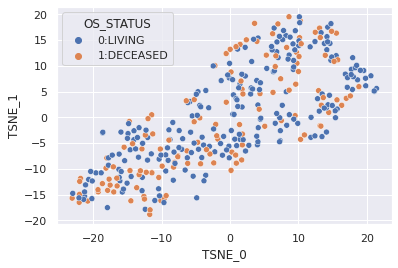

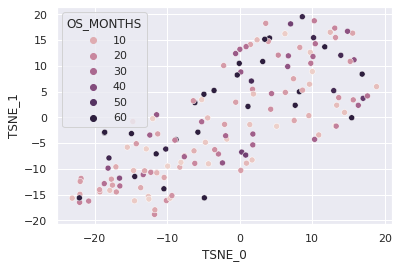

,TSNE_0,TSNE_1,PATIENT_ID,OS_STATUS,OS_MONTHS,OS_STATUS_B
0,18.653875,7.270946,TCGA-NC-A5HG-01,0:LIVING,60.00,False
1,-8.303844,-12.194242,TCGA-39-5035-01,0:LIVING,60.00,False
2,-18.150360,-9.855801,TCGA-60-2704-01,1:DECEASED,37.91,True
3,15.531543,11.965858,TCGA-39-5027-01,0:LIVING,60.00,False
4,-0.566056,12.374533,TCGA-22-4601-01,1:DECEASED,34.72,True
...,...,...,...,...,...,...
351,10.190080,18.352764,TCGA-85-8354-01,0:LIVING,32.69,False
352,7.827109,16.841684,TCGA-34-5240-01,0:LIVING,50.62,False
353,6.702156,11.926029,TCGA-58-A46K-01,1:DECEASED,34.33,True
354,-2.382804,-8.844244,TCGA-39-5034-01,1:DECEASED,36.37,True


In [113]:
n_components = 2
df_plot = pd.DataFrame(
    dim_reduction(n_components).fit_transform(significant_factors),
    #    if significant_factors.shape[-1] > 2 else
    #significant_factors,
    columns=[dim_reduction_label.format(i) for i in range(n_components)]
)    
df_plot = df_plot.join(df_clin.reset_index())
sns.scatterplot(data=df_plot, x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_STATUS")
plt.show()
sns.scatterplot(data=df_plot[df_plot["OS_STATUS_B"]], x=dim_reduction_label.format(0), y=dim_reduction_label.format(1), hue="OS_MONTHS")
plt.show()
df_plot

### Working Back Features from Factors

## Cluster Samples

In [114]:
for k in range(2,6):
    kmeans = KMeans(k)
    kmeans.fit(significant_factors)
    labels = kmeans.labels_
    silhouette = silhouette_score(factor_df, labels)
    CH_score = calinski_harabasz_score(factor_df, labels)
    print("k="+str(k))
    print("Silhouette score:", silhouette)
    print("CH score", CH_score)
    print()

k=2
Silhouette score: 0.0402719155631351
CH score 5.91344333743486

k=3
Silhouette score: 0.014063618843531375
CH score 5.695040538829435

k=4
Silhouette score: -0.025766248382449584
CH score 3.0525374309738513

k=5
Silhouette score: -0.054200727985141174
CH score 3.35216732221816



log-rank P value: 0.1756659332341483


<AxesSubplot:xlabel='timeline'>

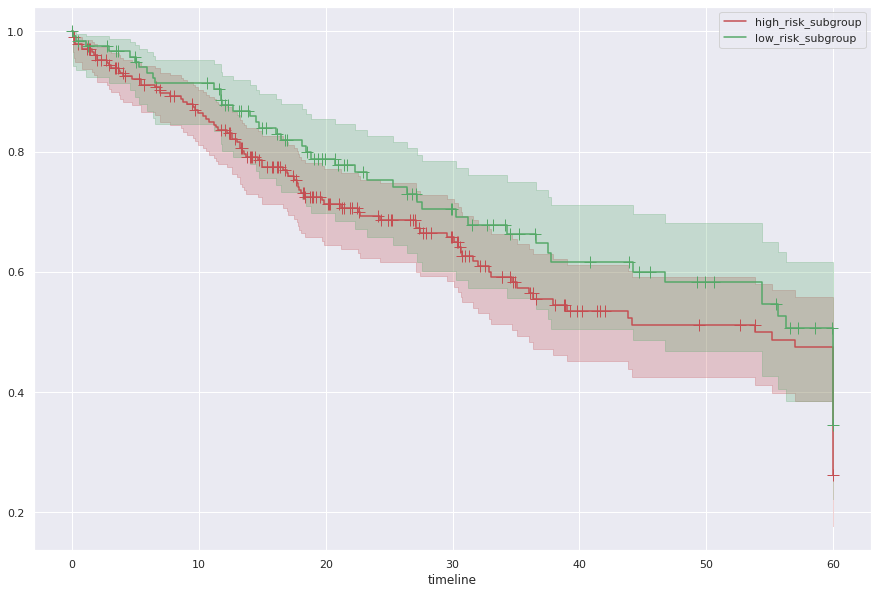

In [115]:
kmeans = KMeans(2).fit(significant_factors)
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, kmeans.labels_)
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
#lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

log-rank P value: 0.7328993198804044


<AxesSubplot:xlabel='timeline'>

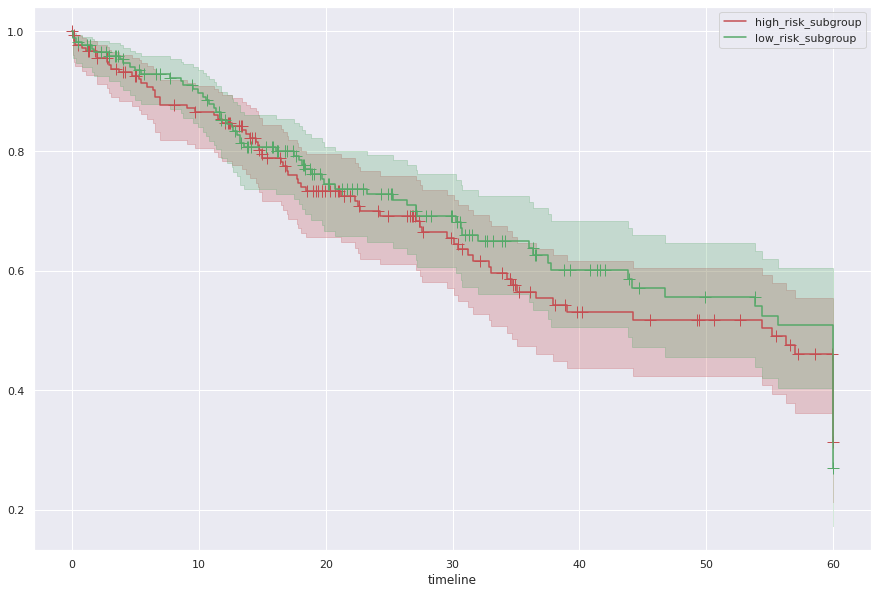

In [101]:
target_features = df_clin.copy()
kmf_low, kmf_high, low_risk_samples, high_risk_samples = kmf_high_low(df_clin, np.random.choice([0,1], size=df_clin.shape[0]))
# Compute the log-rank test P value between the 2 survival functions
results = lifelines.statistics.logrank_test(high_risk_samples["OS_MONTHS"], low_risk_samples["OS_MONTHS"],
                       high_risk_samples["OS_STATUS_B"], low_risk_samples["OS_STATUS_B"])
print("log-rank P value:",results.p_value)
plt.figure(figsize=(15,10))
ax = plt.gca()
kmf_high.plot(show_censors=1, ci_show=1, color="r", ax=ax)
kmf_low.plot(show_censors=1, ci_show=1, color="g", ax=ax)
#lifelines.plotting.add_at_risk_counts(kmf_high, kmf_low, ax=ax)

In [83]:
target_features = df_clin.copy()
target_features["Risk_subgroup"] = kmeans.labels_
target_features

,OS_STATUS,OS_MONTHS,OS_STATUS_B,Risk_subgroup
PATIENT_ID,,,,
TCGA-NC-A5HG-01,0:LIVING,60.00,False,1
TCGA-39-5035-01,0:LIVING,60.00,False,0
TCGA-60-2704-01,1:DECEASED,37.91,True,0
TCGA-39-5027-01,0:LIVING,60.00,False,1
TCGA-22-4601-01,1:DECEASED,34.72,True,1
...,...,...,...,...
TCGA-85-8354-01,0:LIVING,32.69,False,1
TCGA-34-5240-01,0:LIVING,50.62,False,1
TCGA-58-A46K-01,1:DECEASED,34.33,True,1


In [76]:
df_mrna
df_lcna
df_methy
df_mirna

,hsa-mir-6511b-2_mirna,hsa-mir-4797_mirna,hsa-mir-376b_mirna,hsa-mir-579_mirna,hsa-mir-221_mirna,hsa-mir-24-2_mirna,hsa-mir-125b-2_mirna,hsa-mir-616_mirna,hsa-mir-1343_mirna,hsa-mir-127_mirna,...,hsa-mir-1307_mirna,hsa-mir-424_mirna,hsa-mir-188_mirna,hsa-mir-101-2_mirna,hsa-mir-190a_mirna,hsa-mir-200c_mirna,hsa-mir-539_mirna,hsa-mir-6842_mirna,hsa-mir-196a-2_mirna,hsa-mir-4661_mirna
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-NC-A5HG-01,1.361926,0.335385,0.607320,1.361926,8.861143,11.051337,7.139723,3.307175,1.033408,8.266740,...,12.218331,5.312288,2.640221,10.902076,2.300330,14.177152,1.854848,1.033408,5.312288,3.228793
TCGA-39-5035-01,0.446221,0.000000,0.000000,0.786540,7.097242,10.536891,6.905556,2.091598,0.000000,7.628040,...,9.590361,6.500312,1.491767,13.423986,1.061707,13.663018,2.419431,2.419431,8.835997,1.061707
TCGA-60-2704-01,0.600756,1.249363,0.426899,0.755898,8.035375,9.604594,8.859482,1.973390,0.426899,10.395749,...,10.345662,5.968944,1.908708,13.402769,1.840990,12.459037,3.041096,2.407152,4.968183,2.541211
TCGA-39-5027-01,0.895286,2.150531,0.895286,0.000000,8.470609,10.817741,9.097135,0.895286,1.102078,8.904327,...,9.922131,6.980370,3.883587,12.524084,3.079488,13.736462,2.240794,2.869182,2.924701,2.554149
TCGA-22-4601-01,1.710226,1.094952,0.000000,1.710226,8.757233,10.590117,7.848524,3.978999,2.470990,7.301737,...,12.217765,5.465004,3.978999,12.777403,3.627677,14.198660,2.470990,2.966497,4.700069,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-8354-01,1.712963,2.861046,0.650382,1.437628,8.522825,11.459372,7.942051,4.501069,1.097050,8.791153,...,12.662289,5.541227,1.437628,11.788068,2.143231,14.641436,0.650382,2.969934,7.745465,3.071177
TCGA-34-5240-01,0.000000,0.000000,0.500673,0.500673,7.346959,10.305055,6.907713,2.110691,0.000000,9.031562,...,10.083010,6.468227,1.620288,13.153292,2.579776,13.054246,3.216835,0.871643,1.166470,1.166470
TCGA-58-A46K-01,1.174273,1.174273,1.174273,2.408439,8.009797,10.112642,6.999277,3.512658,1.174273,8.809276,...,10.715232,6.052092,2.018708,11.850754,1.174273,13.484349,2.141200,1.737271,5.497204,1.387293


In [77]:
SelectKBest, f_classif

(sklearn.feature_selection._univariate_selection.SelectKBest,
 <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>)

Voting scheme
FPKM/TPM
Bioconductor workshops